In [5]:
import numpy as np
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import qr


def unitary(phi, omega, theta):
    a1 = np.exp(-1j*(phi + omega)/2)*np.cos(theta/2)
    a2 = -np.exp(1j*(phi - omega)/2) *np.sin(theta/2)
    a3 = np.exp(-1j*(phi - omega)/2) * np.sin(theta/2)
    a4 = np.exp(1j*(phi + omega)/2) * np.cos(theta/2)
    U = np.array([[a1, a2], [a3, a4]])
    return U
    
# define n-tangle

def n_tangle(psi, N):
    # <psi| sigma_y^{tensor n} |psi*>
    
    # how many qubits: N
    assert 2**N == len(psi), "state vector length must be 2^n"
    # n tangle of odd qubits is 0
    if N % 2 == 1:
        return 0.0

    # single-qubit sigma_y
    sy = np.array([[0, -1j],[1j, 0]])

    # build sigma_y^{⊗N}
    Sy = sy
    for _ in range(N-1):
        Sy = np.kron(Sy, sy)

    # spin-flipped state
    psi_star = np.conjugate(psi)
    psi_tilde = Sy.dot(psi_star)

    z = np.dot(psi, psi_tilde)
    z_conj = np.conjugate(z)
    # return sqrt (zz*)
    return np.sqrt(z*z_conj)

# in order to estimate L^tau, we must take the maximum of tau bar_beta over beta local... what does this mean?
# beta is LOCAL: implies each qubit has its own basis?

# tensor all Us together: should be an array of unitaries []
def U_tensored(Us):
    U_p = Us[0]
    for i in range(1, len(Us)):
        U_p = np.kron(U_p, Us[i])
    return U_p
# get arg max_U tau bar _U (GHZ) = H

# using an optimizer instead of brute force:
# let angles be an array of angle sets: [{theta_1, phi_1, omega_1}, {theta_2, phi_2, omega_2},...]
def tau_bar(angles, psi, n_A, n_B):
    # d_A = 2**(n_A)
    d_B = 2**(n_B)
    Us = [] # store all unitaries that should be tensored
    if n_A == 1:
        U = unitary(angles[0], angles[1], angles[2])
    else:
        for i in range(0, len(angles), 3):
            theta = angles[i]
            phi = angles[i + 1]
            omega = angles[i + 2] 
            Us.append(unitary(theta, phi, omega))
        assert(len(Us) == n_A)
        U = U_tensored(Us) 
    
    # the two measurement outcomes:
    m0 = U[:,0]    
    m1 = U[:,1]    
    
    # build projectors ⟨m_i|⊗I
    I_B = np.eye(d_B)
    M0 = np.kron(m0.conj().T, I_B)   
    # print("Mo.shape", M0.shape)
    
    M1 = np.kron(m1.conj().T, I_B)
    # print("M1 shape", M1.shape)
    
    # apply and get probabilities + post‐states
    post0 = M0 @ psi
    post1 = M1 @ psi
    p0 = np.vdot(post0, post0).real
    p1 = np.vdot(post1, post1).real
    
    # if either branch is essentially zero, penalize heavily
    if p0 < 1e-12 or p1 < 1e-12:
        return 1e3 + (p0+p1)  # large positive
    
    psi0 = post0 / np.sqrt(p0)
    psi1 = post1 / np.sqrt(p1)
    
    # compute 2-tangles
    t0 = n_tangle(psi0, n_B)
    t1 = n_tangle(psi1, n_B)
    
    # weighted average, negated (since we minimize)
    return -(p0*t0 + p1*t1)

# use optimizer over L_tau
def L_tau_opt(psi, n_A, n_B):
    # initial guess: random angles in [0,2π): scales with n_A
    x0 = np.random.rand(3*n_A) * 2*np.pi
    
    # constraints 0 ≤ x[i] ≤ 2π as inequality funcs for COBYLA: angle constraints (obvious)
    cons = []
    for i in range(3*n_A):
        cons.append({'type':'ineq', 'fun': lambda x, i=i: x[i]})
        cons.append({'type':'ineq', 'fun': lambda x, i=i: 2*np.pi - x[i]})
    
    res = minimize(
        tau_bar, x0,
        args=(psi, n_A, n_B),
        method='COBYLA',
        constraints=cons,
        options={'maxiter': 500, 'tol':1e-6, 'rhobeg':1.0}
    )
    
    # theta_opt, phi_opt, omega_opt = res.x
    max_Ltau = -res.fun
    # return max_Ltau, (theta_opt, phi_opt, omega_opt)
    return max_Ltau

# sample uniformly at random via haar measure

def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    U = np.dot(Q, Lambda)
    return U[:,0] # first col is a random unitary

def estimate_L_tau(nA, nB, N_samples=100):
    Ls = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))
        # print("psi.shape:", psi.shape,          "expected:", (2**nA * 2**nB,))
        Li = L_tau_opt(psi, nA, nB)
        Ls[i] = Li
    mean = Ls.mean()
    return mean

def L_vs_dB(nA, nB_values, N_samples=200):
    means = []
    for nB in nB_values:
        mean = estimate_L_tau(nA, nB, N_samples)
        means.append(mean)
    return np.array(means)

def L_vs_dA(nAs, nB, N_samples=200):
    means = []
    for nA in nAs:
        mean = estimate_L_tau(nA, nB, N_samples)
        means.append(mean)
    return np.array(means)




n_A=1: L = 0.0123 n_B² + -0.2000 n_B + 0.8903
n_A=2: L = 0.0094 n_B² + -0.1518 n_B + 0.6665
n_A=3: L = 0.0065 n_B² + -0.1030 n_B + 0.4451


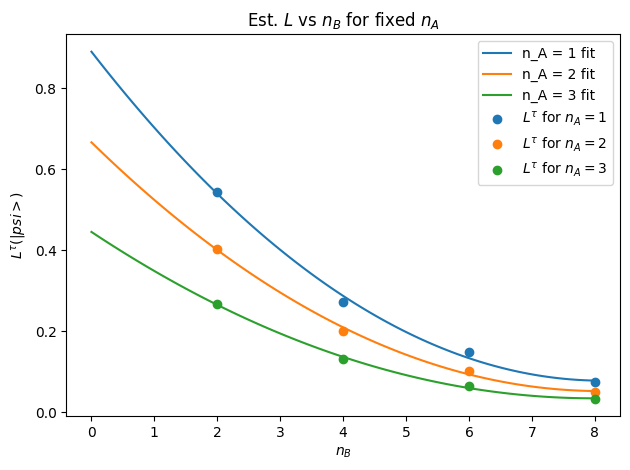

In [ ]:
# Ltau vs nA with exponential fitting:
nA = 1
nA3 = 3
nA2 = 2



# 2) Choose a range of dB values that you can feasibly simulate.
#    (Remember: your state‐space dimension is 2**(dA+dB).)
nB_one = list(range(2, 9, 2))
nB_two = list(range(2, 9, 2))
nB_three = list(range(2, 9, 2)) 

# 3) Run the sweep
means = L_vs_dB(nA, nB_one, N_samples=200)
means2 = L_vs_dB(nA2, nB_two, N_samples=200)
means3=L_vs_dB(nA3, nB_three, N_samples=200)

# fit a curve
deg = 2  # try 1 (linear), 2 (quadratic), … up to 4 for five pts
coeffs = np.polyfit(nB_one, means, deg)
poly = np.poly1d(coeffs)
a, b, c = coeffs
print(f"n_A=1: L = {a:.4f} n_B² + {b:.4f} n_B + {c:.4f}")

x_fit = np.linspace(0, 8, 100)
y_fit = poly(x_fit)  # or fitted(x_fit)

plt.plot(x_fit, y_fit,  
         color='C0',    
         label='n_A = 1 fit')

coeffs2 = np.polyfit(nB_two, means2, deg)
poly2 = np.poly1d(coeffs2)
a2, b2, c2 = coeffs2
print(f"n_A=2: L = {a2:.4f} n_B² + {b2:.4f} n_B + {c2:.4f}")

x_fit2 = np.linspace(0, 8, 100)
y_fit2 = poly2(x_fit2)  # or fitted(x_fit)

plt.plot(x_fit2, y_fit2, 
         color='C1',     
         label='n_A = 2 fit')

coeffs3 = np.polyfit(nB_three, means3, deg)
poly3 = np.poly1d(coeffs3)
a3, b3, c3 = coeffs3
print(f"n_A=3: L = {a3:.4f} n_B² + {b3:.4f} n_B + {c3:.4f}")

x_fit3 = np.linspace(0, 8, 100)
y_fit3 = poly3(x_fit3)  # or fitted(x_fit)

plt.plot(x_fit3, y_fit3,  
         color='C2',    
         label='n_A = 3 fit')


plt.errorbar(nB_one, means, fmt='o', color='C0',label=r'$L^{\tau}$ for $n_A = 1$')
plt.errorbar(nB_two, means2, fmt='o', color='C1', label=r'$L^{\tau}$ for $n_A = 2$')
plt.errorbar(nB_three, means3, fmt='o', color='C2', label=r'$L^{\tau}$ for $n_A = 3$')
plt.xlabel(r'$n_B$')
plt.ylabel(r'$L^{\tau}(|psi>)$')
plt.title(f'Est. $L$ vs $n_B$ for fixed $n_A$')
plt.legend()
plt.tight_layout()
plt.show()



c:\Users\abbie\miniconda3\envs\qis102\Lib\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


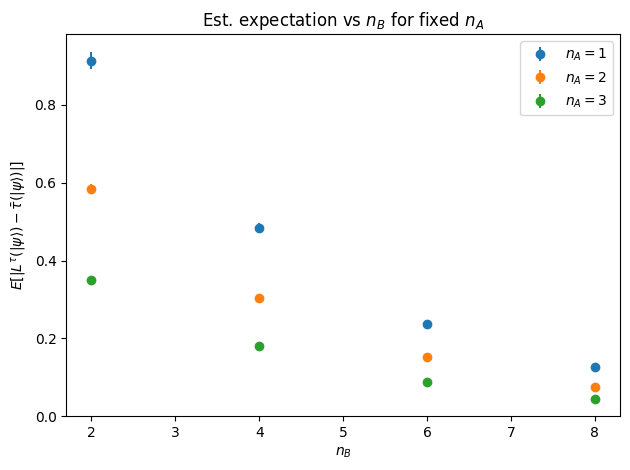

In [56]:
# numerically show E_|psi> [|L^t(|psi>) - taubar_beta (|psi>)|]

# function to compute L^tau(psi) - _tau_beta (psi) for psi sampled uniformly at random and beta random basis.
def L_tau_bar_difference(psi, n_A, n_B):
    angles = np.random.rand(3*n_A) * 2*np.pi
    return np.abs(L_tau_opt(psi, n_A, n_B) - tau_bar(angles, psi, n_A, n_B))

def E_L_tau_bar_difference(n_A, n_B, num_samples=200):
    diffs = np.zeros(num_samples)
    for i in range(num_samples):
        psi = qr_haar(2**(n_A + n_B))
        diffs[i] = L_tau_bar_difference(psi, n_A, n_B)
    return diffs.mean()

#now, compute the Expectation value for various d_A, d_B values:

nA  = 1
nA2 = 2
nA3 = 3
nB_list  = list(range(2, 9, 2))   # [2, 4, 6]

N_samples = 200

# preallocate
diff_means = np.zeros(len(nB_list))
diff_stderr= np.zeros(len(nB_list))

diff_means2 = np.zeros(len(nB_list))
diff_stderr2= np.zeros(len(nB_list))

diff_means3 = np.zeros(len(nB_list))
diff_stderr3= np.zeros(len(nB_list))

# Monte Carlo sweep
for idx, nB in enumerate(nB_list):
    samples = np.zeros(N_samples)
    samples2 = np.zeros(N_samples)
    samples3 = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))
        samples[i] = L_tau_bar_difference(psi, nA, nB)

        psi2 = qr_haar(2**(nA2 + nB))
        samples2[i] = L_tau_bar_difference(psi2, nA2, nB)

        psi3 = qr_haar(2**(nA3 + nB))
        samples3[i] = L_tau_bar_difference(psi3, nA3, nB)


    diff_means[idx]   = samples.mean()
    diff_stderr[idx]  = samples.std(ddof=1)/np.sqrt(N_samples)

    diff_means2[idx]   = samples2.mean()
    diff_stderr2[idx]  = samples2.std(ddof=1)/np.sqrt(N_samples)

    diff_means3[idx]   = samples3.mean()
    diff_stderr3[idx]  = samples3.std(ddof=1)/np.sqrt(N_samples)

# Plot
plt.errorbar(
    nB_list, diff_means,
    yerr=diff_stderr,
    fmt='o', color='C0',
    label=r'$n_A = 1$'
)

plt.errorbar(
    nB_list, diff_means2,
    yerr=diff_stderr2,
    fmt='o', color='C1',
    label=r'$n_A = 2$'
)

plt.errorbar(
    nB_list, diff_means3,
    yerr=diff_stderr3,
    fmt='o', color='C2',
    label=r'$n_A = 3$'
)
plt.xlabel(r'$n_B$')
plt.ylabel(r'$E[|L^{\tau}(|\psi \rangle)-\bar\tau(|\psi \rangle)|]$')
plt.title(f'Est. expectation vs $n_B$ for fixed $n_A$')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# get NB = const curves for nA = 2, 6
nB = 2
nB2 = 4
nB3 = 6


nA = list(range(2, 7))
means = L_vs_dA(nA, nB, N_samples=200)
means2 = L_vs_dA(nA, nB2)
means3 = L_vs_dA(nA, nB3)


plt.errorbar(nA, means, fmt='o', color='C0',label=r'$L^{\tau}$ for $n_B = 2$')
plt.errorbar(nA, means2, fmt='o', color='C1',label=r'$L^{\tau}$ for $n_B = 4$')
plt.errorbar(nA, means3, fmt='o', color='C2',label=r'$L^{\tau}$ for $n_B = 6$')


plt.xlabel(r'$n_A$')
plt.ylabel(r'$L^{\tau}(|psi>)$')
plt.title(f'Est. $L$ vs $n_A$ for fixed $n_B$')
plt.legend()
plt.tight_layout()
plt.show()




KeyboardInterrupt: 

c:\Users\abbie\miniconda3\envs\qis102\Lib\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


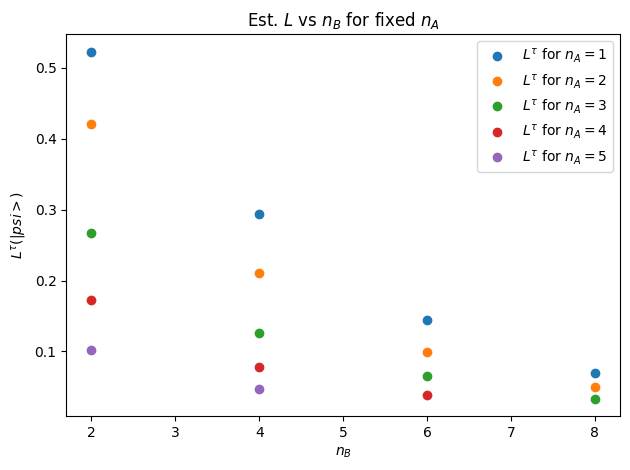

In [ ]:
# L vs nA for nA large- no polynomial fitting
nA = 1
nA3 = 3
nA2 = 2
nA4 = 4
nA5 = 5



# 2) Choose a range of dB values that you can feasibly simulate.
#    (Remember: your state‐space dimension is 2**(dA+dB).)
nB_one = list(range(2, 9, 2))
nB_two = list(range(2, 9, 2))
nB_three = list(range(2, 9, 2)) 
nB_four = list(range(2, 7, 2))
nB_five = list(range(2, 5, 2))


# 3) Run the sweep
means = L_vs_dB(nA, nB_one, N_samples=100)
means2 = L_vs_dB(nA2, nB_two, N_samples=100)
means3=L_vs_dB(nA3, nB_three, N_samples=100)
means4 = L_vs_dB(nA4, nB_four, N_samples=100)
means5 = L_vs_dB(nA5, nB_five, N_samples=100)

plt.errorbar(nB_one, means, fmt='o', color='C0',label=r'$L^{\tau}$ for $n_A = 1$')
plt.errorbar(nB_two, means2, fmt='o', color='C1', label=r'$L^{\tau}$ for $n_A = 2$')
plt.errorbar(nB_three, means3, fmt='o', color='C2', label=r'$L^{\tau}$ for $n_A = 3$')
plt.errorbar(nB_four, means4, fmt='o', color='C3', label=r'$L^{\tau}$ for $n_A = 4$')
plt.errorbar(nB_five, means5, fmt='o', color='C4', label=r'$L^{\tau}$ for $n_A = 5$')
plt.xlabel(r'$n_B$')
plt.ylabel(r'$L^{\tau}(|psi>)$')
plt.title(f'Est. $L$ vs $n_B$ for fixed $n_A$')
plt.legend()
plt.tight_layout()
plt.show()

